In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

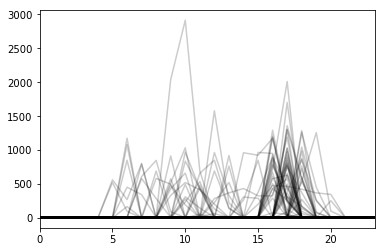

In [30]:
pd.DataFrame(train_appliance['oven']).T.plot(legend=False, color='k',alpha=0.2)

In [19]:
pd.DataFrame(train_appliance['mw']).corrwith(pd.DataFrame(train_appliance['oven']))

0    -0.126893
1    -0.112627
2    -0.111376
3    -0.048266
4     0.007701
5    -0.018865
6     0.072901
7     0.031823
8     0.096118
9     0.098100
10    0.002096
11   -0.000474
12    0.053790
13    0.151189
14   -0.003528
15   -0.011850
16    0.005128
17   -0.016421
18    0.040137
19   -0.033456
20    0.191945
21   -0.062418
22   -0.072402
23   -0.108893
dtype: float64

In [30]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

In [36]:
pred_appliance = {}
for appliance in APPLIANCES_ORDER[1:]:
    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    from keras import regularizers
    agg_input = keras.layers.Input(shape=[24],name='Aggregate')
    appliance_dense_1 = keras.layers.Dense(units=20,name='Appliance-layer-1',activation='relu')(agg_input)
    dropout = keras.layers.Dropout(rate=0.3,name='Droput-Appliance')(appliance_dense_1)




    out = keras.layers.Dense(units=24,name='Appliance-output',activation='relu')(dropout)
    out = Minimum(name='Clip-to-agg')([out, agg_input])


    model = keras.Model(agg_input, out)
    model.compile('adam','mean_absolute_error')
    model.fit(train_agg, train_appliance[appliance], epochs=300, validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg)



hvac
********************
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 0s 1ms/step - loss: 661.6838 - val_loss: 666.3338
Epoch 2/300
378/378 [==============================] - 0s 50us/step - loss: 591.9552 - val_loss: 590.7587
Epoch 3/300
378/378 [==============================] - 0s 51us/step - loss: 520.2719 - val_loss: 519.7037
Epoch 4/300
378/378 [==============================] - 0s 51us/step - loss: 454.8880 - val_loss: 450.5059
Epoch 5/300
378/378 [==============================] - 0s 52us/step - loss: 389.6605 - val_loss: 381.3647
Epoch 6/300
378/378 [==============================] - 0s 51us/step - loss: 340.8408 - val_loss: 325.7024
Epoch 7/300
378/378 [==============================] - 0s 54us/step - loss: 311.5913 - val_loss: 279.7422
Epoch 8/300
378/378 [==============================] - 0s 54us/step - loss: 274.5177 - val_loss: 252.5243
Epoch 9/300
378/378 [==============================] - 0s 58us/step - loss: 253.16

Epoch 77/300
378/378 [==============================] - 0s 56us/step - loss: 127.6365 - val_loss: 139.5523
Epoch 78/300
378/378 [==============================] - 0s 50us/step - loss: 127.8330 - val_loss: 139.5443
Epoch 79/300
378/378 [==============================] - ETA: 0s - loss: 129.608 - 0s 58us/step - loss: 128.1786 - val_loss: 139.5379
Epoch 80/300
378/378 [==============================] - 0s 50us/step - loss: 128.0439 - val_loss: 139.5374
Epoch 81/300
378/378 [==============================] - 0s 52us/step - loss: 127.8161 - val_loss: 139.5313
Epoch 82/300
378/378 [==============================] - 0s 46us/step - loss: 127.6848 - val_loss: 139.5253
Epoch 83/300
378/378 [==============================] - 0s 52us/step - loss: 127.7055 - val_loss: 139.5151
Epoch 84/300
378/378 [==============================] - 0s 56us/step - loss: 127.8220 - val_loss: 139.4930
Epoch 85/300
378/378 [==============================] - 0s 56us/step - loss: 127.5482 - val_loss: 139.4731
Epoch 86/30

KeyboardInterrupt: 

In [37]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
Appliance-layer-1 (Dense)       (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-Appliance (Dropout)      (None, 20)           0           Appliance-layer-1[0][0]          
__________________________________________________________________________________________________
Appliance-output (Dense)        (None, 24)           504         Droput-Appliance[0][0]           
__________________________________________________________________________________________________
minimum_2 

In [32]:
mae = {}
for appliance in APPLIANCES_ORDER[1:]:
    mae[appliance] = mean_absolute_error(test_appliance[appliance], pred_appliance[appliance])
    
    

In [34]:
pd.Series(mae)

dw         14.515641
fridge     42.986721
hvac      135.127259
mw          6.303220
oven       19.784436
wm          5.618949
dtype: float64

In [24]:
pred_hvac.shape

(308, 24)

In [27]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_fridge))
print(mean_absolute_error(pred_hvac, test_agg))




41.4446940174
996.766596489


In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

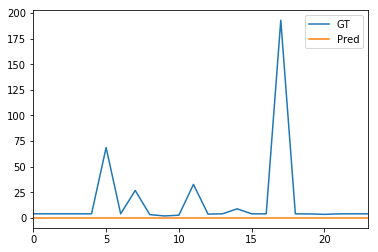

In [284]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()